
# VisEcho
## By Stephen Gregory and Stephen Kirby


<a href="https://colab.research.google.com/github/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/Hackathon_NMR_Challenge.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


### Problem Statement

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins start aligned, begin to disperse, and are then refocused. This creates a sharp peak, or "echo", in the net magnetization $M$ of the material at a later time. When the spins interact with each other, this refocused echo can become highly distorted.
- Materials with strong electron-electron couplings have a variety of applications, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- Design and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$.

Before getting to any code, we first review the structure of this machine learning problem and introduce some of the details of the underlying physics we are trying to capture.




## Quick description of the ML problem

### Goal:
Predict four real numbers from a large input vector of real numbers.

### Example Solution:  Multilayer Neural Network:

To get the complex-valued time-series $M(t)$ into a neural network, we can simply "stack" the real and complex parts together to make a real-valued input vector.

![simple_neural_net_drawing.png](https://github.com/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/simple_neural_net_drawing.png?raw=1)

### Example Solution's Figures of Merit:

Using the simple neural network with 15 epochs (the code below only uses 3, for speed), we obtain the following predictions of the four output variables from the $M(t)$ curves:

![simple_solution_15epochs.png](https://github.com/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/simple_solution_15epochs.png?raw=1)

Note that one of these (correlation strength) is predicted very well, two are partially captured (the correlation and dissipation power), and one is not captured at all (correlation length).



## Introduction to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!


![NMR Spin Echo Animation](https://github.com/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/HahnEcho_GWM.gif?raw=1)


The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a spin-echo in most materials:

![standard_spinecho.png](https://github.com/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/standard_spinecho.png?raw=1)

Sometimes, a more complicated curve can occur, such as:

![coupled_echo.png](https://github.com/ML4SCIHackathon/ML4SCI/blob/main/NMRSpinChallenge/coupled_echo.png?raw=1)

This more complicated structure has been caused by spin-spin interactions between the precessing nuclear spins. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough (enhanced perhaps by a "qunatum" electronic phase), then a non-neglible two-step process can couple the nuclei with each other throughout the material.
That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$, given by:

$T(i,j) = \alpha \left( \frac{ \left|r_j - r_i \right|}{\xi} \right)^{-p}$

where $\alpha$ is the coupling strength, $\xi$ the coupling length, and $p$ the power-law of the coupling.
Generally, $\alpha$, $\xi$, and $p$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if the spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost".
This occurs at a time scale $T_\textrm{decay} \simeq \Gamma^{-1/2}$, with $\Gamma$ given by:

$\Gamma = 10^{-d}$

In the simulated data-sets, the parameters are randomly distributed over the following ranges:
- $\alpha$: coupling strength $\in$ [0.0, 0.2]
- $\xi$: coupling length $\in$ [0, 20]
- $p$: coupling power $\in$ [2, 4]
- $d$: dissipation power $\in$ [3, 6]

Our goal is to develop a model that accurately determines the above four variables from a single $M(t)$ curve.

## Load and view the simulated data

Three data-files will be used for the training of the model. Each has 10,000 lines, representing 10,000 simulated $M(t)$ curves for different choices of the four material parameters:

- echos_r.txt  : Real part of the time-dependent magnetization, $\textrm{Re}(M(t))$.
- echos_i.txt  : Imaginary part of the time-dependent magnetization, $\textrm{Im}(M(t))$.
- mat_info.txt : The four material parameters ($\alpha$,$\xi$,$p$,$d$) introduced above.

We also load two smaller files, which give the 500 $M(t)$ curves to be used in submitting your solution to the challenge:

- submit_echos_r.txt
- submit_echos_i.txt

In [ ]:
!pip install -U numpy
import numpy as np
import matplotlib.pyplot as plt
import requests

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1UZ8wy1Vh4iW1GyaBfWtmjnrKXeDmA2rJ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1G82krEg6SVB-PFOS3ei-EH4ZOcseSIEe",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1h8MHtV_rQg4TG-YGXqRaDzJU8oRrypCD",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=14-oz_3OGsTFziJI1FUg0EenMcdQDf2F_",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Add2V9cYOBbOCvr1Dj-g4yMlx3LdJY8i",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.3)
Done with file downloads
Loading into numpy arrays...
Done with numpy loads


#### Load Pytorch Modules

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
print(torch.cuda.device_count())

1


#### Data Standardization and Normalization

In [ ]:
# Data Normalization

def norm(arr):
    """ Normalize numpy array. """
    aMin = np.min(arr)
    aMax = np.max(arr)
    normalized = (arr - aMin) / (aMax - aMin)
    return normalized, aMin, aMax

def de_norm(val, aMin, aMax):
    """ De-normalize numpy array. """
    denormalized = val * (aMax - aMin) + aMin
    return denormalized


In [ ]:
# Data Standardization

def standardize(arr):
    """ Standardize numpy array. """
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0)
    arr = (arr - mean) / std
    return arr, mean, std


def de_standardize(arr, mean, std):
    """ Reverse Standardization for post-processing analysis. """
    rev_arr = (arr * std) - mean
    rev_arr = np.abs(rev_arr)
    return np.flip(rev_arr)

In [ ]:
### Standardize Labels ###

# Alpha, coupling strength, [0.0, 0.2]
alpha, alpha_mean, alpha_std = standardize(mat_info[:,0])

# Xi, coupling length, [0, 20]
xi, xi_mean, xi_std = standardize(mat_info[:,1])

# rho, coupling power, [2,4]
rho, rho_mean, rho_std = standardize(mat_info[:,2])

# d, dissapation power, [3,6]
d, d_mean, d_std = standardize(mat_info[:,3])

# Re-stack standardized arrays
mat_standardized = np.stack((alpha, xi, rho, d), axis=1)

In [ ]:
### Normalize Labels ### 

# Alpha, coupling strength, [0.0, 0.2]
alpha, alpha_min, alpha_max = norm(mat_info[:,0])

# Xi, coupling length, [0, 20]
xi, xi_min, xi_max = norm(mat_info[:,1])

# rho, coupling power, [2,4]
rho, rho_min, rho_max = norm(mat_info[:,2])

# d, dissapation power, [3,6]
d, d_min, d_max = norm(mat_info[:,3])

# Re-stack normalized arrays
mat_normalized = np.stack((alpha, xi, rho, d), axis=1)

In [ ]:
### Normalize input ###

# Normalize real component of input data
M_r_norm, M_r_min, M_r_max = norm(M_r)

# Normalize imaginary component of input data
M_i_norm, M_i_min, M_i_max = norm(M_i)

# Combine real and imaginary parts of data back together again
M_norm = M_r_norm + 1j*M_i_norm

In [ ]:
### Standardize input ###

# Standardize real component of input data
M_r_standardized, M_r_mean, M_r_std = standardize(M_r)

# Standardize imaginary component of input data
M_i_standardized, M_i_mean, M_i_std = standardize(M_i)

# Combine real and imaginary parts of data back together again
M_standardized = M_r_standardized + 1j*M_i_standardized

### Preprocessing

In [ ]:
### Partition into Training/Testing with Standardized/Normalized Values ###

test_frac = 0.10  # fraction of data to save for testing data
val_frac = 0.10  # fraction of data to save for validation data
stackIR = True

import numpy as np
def pre_process(arr, train_idx, val_idx, test_idx, time_keep, stackIR=False):
    ''' Takes ndarray of imaginary and real values, creates a 2d array [[real, imag], ...] '''

    def IR_reshape(arr, split_idx):
        ''' Reshapes array of imaginary and real numbers into an array of float tuples. '''
        # Take only a portion of the source array
        split_arr = arr[split_idx[:,None], time_keep]
        
        if stackIR:
            # Stack real and imaginary values along the third axis
            split_arr = np.dstack((np.real(split_arr), np.imag(split_arr)))     
        else:
            # concatenate real and imaginary values 
            split_arr = np.hstack((np.real(split_arr), np.imag(split_arr)))     
        
        split_arr = np.expand_dims(split_arr, axis=2)

        return split_arr

    # Get Training and testing tensors using previously established function
    train_arr = IR_reshape(arr, train_idx)
    val_arr = IR_reshape(arr, val_idx)
    test_arr  = IR_reshape(arr, test_idx)
    return train_arr, val_arr, test_arr


# number of M(t) curves
N_data = M.shape[0]
train_frac = 1.0 - val_frac - test_frac

train_div_idx = int(np.floor((train_frac)*N_data)) # integer number of curves to use for training
val_div_idx = int(np.floor((train_frac+val_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data) # random ordering for all curves

train_idx, val_idx, test_idx = order_seed[0:train_div_idx], order_seed[train_div_idx:val_div_idx], order_seed[val_div_idx:N_data] # Split Index 

# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(0,410); # centered roughly at the echo


# Standardized
X_train_std, X_val_std, X_test_std = pre_process(M_standardized, train_idx, val_idx, test_idx, time_keep, stackIR)
Y_train_std = mat_standardized[train_idx,:];
Y_val_std   = mat_standardized[val_idx,:];
Y_test_std  = mat_standardized[test_idx,:];
print("Created Normalized Set:\nX_train_std:", X_train_std.shape, "   Y_train_std:", Y_train_std.shape)
print("X_test_std: ", X_test_std.shape, "   Y_test_std:", Y_test_std.shape)
print("X_val_std:  ", X_val_std.shape, "   Y_val_std:", Y_val_std.shape, '\n')

# Normalized
X_train_norm, X_val_norm, X_test_norm = pre_process(M_norm, train_idx, val_idx, test_idx, time_keep, stackIR)
Y_train_norm = mat_normalized[train_idx,:];
Y_val_norm   = mat_normalized[val_idx,:]; 
Y_test_norm  = mat_normalized[test_idx,:]; 
print("Created Normalized Set:\nX_train_norm:", X_train_norm.shape, "   Y_train_norm:", Y_train_norm.shape)
print("X_test_norm: ", X_test_norm.shape, "   Y_test_norm:", Y_test_norm.shape)
print("X_val_norm:  ", X_val_norm.shape, "   Y_val_norm:", Y_val_norm.shape, '\n')

# Default
X_train, X_val, X_test = pre_process(M, train_idx, val_idx, test_idx, time_keep, stackIR)
Y_train = mat_info[train_idx,:];
Y_val   = mat_info[val_idx,:];
Y_test  = mat_info[test_idx,:];
print("Created Default Set:\nX_train:", X_train.shape, "   Y_train:", Y_train.shape)
print("X_test: ", X_test.shape, "   Y_test:", Y_test.shape)
print("X_val:  ", X_val.shape, "   Y_val:", Y_val.shape, '\n')

Created Normalized Set:
X_train_std: (8000, 410, 1, 2)    Y_train_std: (8000, 4)
X_test_std:  (1000, 410, 1, 2)    Y_test_std: (1000, 4)
X_val_std:   (1000, 410, 1, 2)    Y_val_std: (1000, 4) 

Created Normalized Set:
X_train_norm: (8000, 410, 1, 2)    Y_train_norm: (8000, 4)
X_test_norm:  (1000, 410, 1, 2)    Y_test_norm: (1000, 4)
X_val_norm:   (1000, 410, 1, 2)    Y_val_norm: (1000, 4) 

Created Default Set:
X_train: (8000, 410, 1, 2)    Y_train: (8000, 4)
X_test:  (1000, 410, 1, 2)    Y_test: (1000, 4)
X_val:   (1000, 410, 1, 2)    Y_val: (1000, 4) 



### Post-Processing

In [ ]:
def post_process_outputs(outputs):
    """ Applies post-processing to outputs of neural net """
    if (isinstance(outputs, torch.Tensor)):
        # Convert outputs from Torch Tensor to numpy array
        outputs = torch.Tensor.cpu(outputs).detach().numpy()

    # Alpha, coupling strength, [0.0, 0.2]
    alpha = de_norm(outputs[:,0], alpha_min, alpha_max)

    # Xi, coupling length, [0, 20]
    xi = de_norm(outputs[:,1], xi_min, xi_max)

    # rho, coupling power, [2,4]
    rho = de_norm(outputs[:,2], rho_min, rho_max)

    # d, dissapation power, [3,6]
    d = de_norm(outputs[:,3], d_min, d_max)
    
    # Re-stack output arrays
    processed_outputs = np.array([alpha, xi, rho, d])
    processed_outputs = np.rollaxis(processed_outputs, 1)
    return torch.from_numpy(processed_outputs)

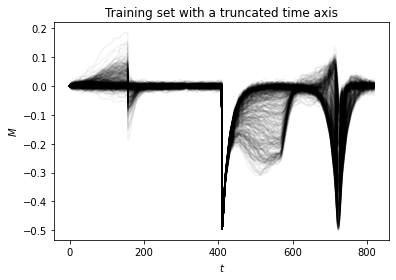

In [ ]:
# partition data into a training and testing set using a random partition

# number of M(t) curves
N_data = M.shape[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10 # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data) # random ordering for all curves

train_idx = order_seed[0:div_idx] # first 90% of random order
test_idx = order_seed[div_idx:N_data] # last 10% of random order

# truncate time points
# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(0,410); # centered roughly at the echo

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train = mat_info[train_idx,:]; # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# (For normalized input) concatenate the real and imaginary parts together, 
# to make a real-vector of double the length
M_train_normalized = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train_normalized = mat_normalized[train_idx,:]; # get the output
M_train_normalized = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# (For standardized input) concatenate the real and imaginary parts together, 
# to make a real-vector of double the length
M_train_standardized = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train_standardized = mat_standardized[train_idx,:]; # get the output
M_train_standardized = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )

# (For normalized input) same as above, but for test
M_test_normalized = M[test_idx[:,None],time_keep]
mat_test_normalized = mat_normalized[test_idx,:];
M_test_normalized = np.hstack( (np.real(M_test), np.imag(M_test)) )

# (For standardized input) same as above, but for test
M_test_standardized = M[test_idx[:,None],time_keep]
mat_test_standardized = mat_standardized[test_idx,:];
M_test_standardized = np.hstack( (np.real(M_test), np.imag(M_test)) )

# plot the fist 500 elements of the training set, for visualizing variations in the data
plt.plot((M_train[1:500,:]).T,color=(0,0,0,.05));
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.title("Training set with a truncated time axis");

### Plot the Data

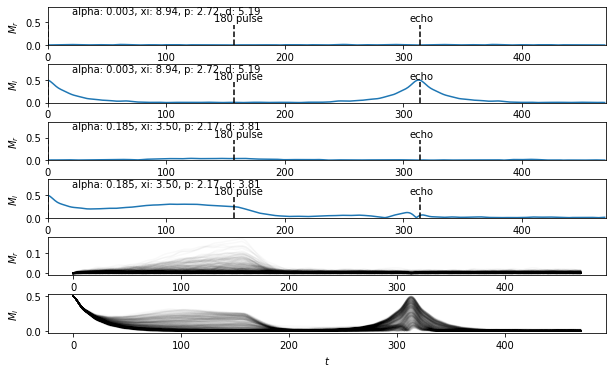

In [ ]:
### SEPARATING REAL AND IMAGINARY COMPONENTS ###

# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(6,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 0; # weak spin-spin coupling
plot_idx2 = 10; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, p: %.2f, d: %.2f";

# view the selected curve, with a label of the material data (real component)
ax1[0].plot(abs(M_r[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$M_r$", xlabel="$t$");

# view the selected curve, with a label of the material data (imaginary component)
ax1[1].plot(abs(M_i[plot_idx1,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$M_i$", xlabel="$t$");

# view the selected curve, with a label of the material data (real component)
ax1[2].plot(abs(M_r[plot_idx2,:]));
ax1[2].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[2].plot([0, 0],[0, .45],'--k')
ax1[2].plot([157, 157],[0, .45],'--k')
ax1[2].text(140,0.52,"180 pulse")
ax1[2].text(305,0.52,"echo")
ax1[2].plot([2*157, 2*157],[0, .45],'--k')
ax1[2].axis([0, 471, 0, 0.85])
ax1[2].set(ylabel="$M_r$", xlabel="$t$");

# view the selected curve, with a label of the material data (imaginary component)
ax1[3].plot(abs(M_i[plot_idx2,:]));
ax1[3].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[3].plot([0, 0],[0, .45],'--k')
ax1[3].plot([157, 157],[0, .45],'--k')
ax1[3].text(140,0.52,"180 pulse")
ax1[3].text(305,0.52,"echo")
ax1[3].plot([2*157, 2*157],[0, .45],'--k')
ax1[3].axis([0, 471, 0, 0.85])
ax1[3].set(ylabel="$M_i$", xlabel="$t$");

# Real component
ax1[4].plot(abs(M_r[1:500,:]).T,color=(0,0,0,.025));
ax1[4].set(ylabel="$M_r$", xlabel="$t$");

# Imaginary component
ax1[5].plot(abs(M_i[1:500,:]).T,color=(0,0,0,.025));
ax1[5].set(ylabel="$M_i$", xlabel="$t$");

fig1.subplots_adjust(hspace=.5)

## ComplexConvNet

Uses alternating point-wise and depth-wise layers.

In [ ]:
### USING FULL INPUT RANGE ###
# Value to apply to LeakyReLU - only tested 0.25 (significant improvement over 0.20)
neg_slope_val = 0.25

class Reshape(nn.Module):
    """ Reshape Channels between Conv and Linear Layers. """
    def forward(self, input):
        new_input = input.squeeze().view(input.size(0), 1, input.size(1))
        #print("Reshaped:", new_input.shape)
        return new_input

class Expand(nn.Module):
    """ Expand (unsqueeze) Tensor. """
    def forward(self, input):
        input = torch.unsqueeze(input, 2)
        #print("Expanded",input.shape)
        return input

class Squeeze(nn.Module):
    """ Squeeze Tensor to convert convolutional layers to linear layers. """
    def forward(self, input):
        input = input.squeeze()
        #print("Squeezed",input.shape)
        return input

class Show(nn.Module):
    """ Squeeze Tensor to convert convolutional layers to linear layers. """
    def forward(self, input):
        
        ### SET SHAPE VERBOSITY ###
        verbose = False
        ### SET SHAPE VERBOSITY ###
        
        if verbose: print(input.shape)
        return input

class ComplexConvNet(nn.Module):
    """
    Simple feed-forward neural network class.

    Uses a convolutional layer at the input to combine real and imaginary
    components of inputs

    Values:
      input_dim: The dimension of the input vector, a scalar
      hidden_dim: The inner dimension, a scalar
      is_stochastic: defines training style, False implies minibatch training (default)
    """

    def __init__(self, input_dim, hidden_dim=32, is_stochastic=False, verbose=False):
        super(ComplexConvNet, self).__init__()
        
        self.input_dim = input_dim         # Define input shape
        self.is_stochastic = is_stochastic # Define Training type
        self.verbose = verbose
        # Build the neural network
        self.net = nn.Sequential(
            #### START CODE HERE ####
            ## Encode Reals/Imags
            self.make_conv_block(input_channels=input_dim,
                                 output_channels=input_dim,
                                 kernel_size=(1,2),
                                 depthwise=True),
            Show(), # (bs, 400, 1, 1)
            ## Compress Encoded Reals/Imags
            Reshape(),
            Show(), # (bs, 1, 400)
            ## Sequence Data Extraction 1
            self.make_conv_block(input_channels=1, 
                                 output_channels=math.floor(self.input_dim / 4), 
                                 kernel_size=5,
                                 stride=5),
            Show(), # (bs, 100, 80)
            Expand(),
            Show(), # (bs, 50, 1, 40)
            ## Depthwise Downsampling 1
            self.make_conv_block(input_channels=math.floor(self.input_dim / 4),
                                 output_channels=math.floor(self.input_dim / 4),
                                 kernel_size=(1,math.floor(self.input_dim / 5)),
                                 depthwise=True),
            Show(), # (bs, 100, 1, 1)
            Reshape(),
            Show(), # (bs, 1, 100)
            ## Sequence Data Extraction 2
            self.make_conv_block(input_channels=1, 
                                 output_channels=math.floor(self.input_dim / 8), 
                                 kernel_size=10,
                                 stride=5),
            Show(), # (bs, 50, 19)
            Expand(),
            Show(), # (bs, 50, 1, 19)
            ## Depthwise Downsampling 2
            self.make_conv_block(input_channels=math.floor(self.input_dim / 8),
                                 output_channels=math.floor(self.input_dim / 8),
                                 kernel_size=(1,19),
                                 depthwise=True),
            Show(), # (bs, 50, 1, 1)
            Reshape(),
            Show(), # (bs, 1, 50)
            ## Sequence Data Extraction 3
            self.make_conv_block(input_channels=1, 
                                 output_channels=math.floor(self.input_dim / 16), 
                                 kernel_size=4,
                                 stride=4),
            Show(), # (bs, 25, 12)
            Expand(),
            Show(), # (bs, 25, 1, 12)
            ## Depthwise Downsampling 3
            self.make_conv_block(input_channels=math.floor(self.input_dim / 16),
                                 output_channels=math.floor(self.input_dim / 16),
                                 kernel_size=(1,12),
                                 depthwise=True),
            Show(), # (bs, 25, 1, 1)
            Squeeze(),
            Show(), # (bs, 25)
            ## Linear Processing / Output
            self.make_simple_block(math.floor(self.input_dim / 16), 4, final_layer=True),

            ### END CODE HERE ###
        )



    def make_conv_block(self, input_channels, output_channels, kernel_size, stride=1, padding=0, depthwise=False):
        '''
        Function to return a sequence of operations corresponding to a convolutional block 
        in the Simple Convolutional Neural Network:
        1. 2D Convolutional Layer
            - Convolutional kernel size is (height, width) where height = 1 and
                width = 2 with a stride of 1
            - There are "num_conv_kernels" convolutional kernels in this block, 
                which should match the number of input data points
        2. Normalizer:
            - batchnorm for minibatch training 
            - layernorm for stochastic 
        3. Activation Function:
            - LeakyReLU 
        Parameters:
            input_channels: How many channels the input feature representation has
            output_channels: How many channels the output feature representation should have
            kernel_size: A Tuple, (height, width) if 2D, an int (height) if 1D, representing 
                the size of the convolutional kernel
            stride: The stride of the convolution operation
            padding: The padding applied to the convolutional operation
            depthwise: True if this should be a depthwise convolutional layer
        '''

        #     Steps:
        #       1) 
        #           If this is a depthwise convolutional layer:
        #               1a) Do a depthwise 2D Convolutional Layer using the given parameters.
        #           Else if this is a regular convolutional layer:
        #               1b) Do a 1D Convolutional Layer using the given parameters.
        #       2) Do a batchnorm.
        #       3) Follow each batchnorm with a ReLU activation.
        
        if depthwise:
            # Build the neural block
            return nn.Sequential(
                #### START CODE HERE ####
                nn.Conv2d(input_channels,
                          input_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          groups=input_channels),
                nn.BatchNorm2d(num_features=input_channels),
                nn.LeakyReLU(negative_slope=neg_slope_val))
                #### END CODE HERE ####
        else:
            # Build the neural block
            return nn.Sequential(
                #### START CODE HERE ####
                nn.Conv1d(input_channels,
                          output_channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding),
                nn.BatchNorm1d(num_features=output_channels),
                nn.LeakyReLU(negative_slope=neg_slope_val))
                #nn.MaxPool2d(kernel_size=kernel_size, stride=stride))
                #### END CODE HERE ####
    

    def make_downsample_block(self, input_channels, output_channels, kernel_size):
        '''
        Create Downsampling or Pooling blocks in neural net.
        '''
        return nn.Sequential(
            #### START CODE HERE ####
            nn.Conv1d(
                input_channels, 
                output_channels,
                kernel_size,
                stride=1,
                groups=input_channels),
                nn.LeakyReLU(negative_slope=neg_slope_val)
            #### END CODE HERE ####
        )


    def make_simple_block(self, input_dim, output_dim, final_layer=False, is_stochastic=False):
        '''
        Function to return a sequence of operations corresponding to a simple block in the 
        Simple Convolutional Neural Network:
        1. Fully connected layer
        2. Normalizer:
            - batchnorm for minibatch training 
            - layernorm for stochastic 
            - none for in the final layer
        3. Activation Function:
            - ReLU 
            - Sigmoid for final layer
        Parameters:
            input_dim: how many dimensions the input feature representation has
            output_dim: how many dimensions the output feature representation should have
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Define the layer normalizer to be used.
        #       2) Do a fully connected layer using the given parameters.
        #       3) Do a batchnorm or layernorm (for stochastic), except for the last layer.
        #       4) Follow each batchnorm with a ReLU activation.
        #       5) If its the final layer, use a Tanh activation after the.
        
        # layer_norm - TODO: Base of input_shape tuple
        if self.is_stochastic: # Layer normalizer for stochastic gradient descent training. 
            layer_norm = nn.LayerNorm(normalized_shape=output_dim)
        else:                  # Layer normalizer for minibatch training. 
            layer_norm = nn.BatchNorm1d(num_features=output_dim)
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.Linear(in_features=input_dim, 
                          out_features=output_dim),
                layer_norm,
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.Linear(in_features=input_dim, 
                          out_features=output_dim),
                nn.Sigmoid()
                #### END CODE HERE ####
            )

    def forward(self, input):
        '''
        Function for completing a forward pass of the network: Given a noise tensor, 
        returns generated images.
        Parameters:
            input: an tensor with dimensions (n_samples, input_dim)
        '''
        return self.net(input)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


complexConvNet = ComplexConvNet(X_train.shape[1])
complexConvNet = complexConvNet.double()
print(complexConvNet);

ComplexConvNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(410, 410, kernel_size=(1, 2), stride=(1, 1), groups=410)
      (1): BatchNorm2d(410, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (1): Show()
    (2): Reshape()
    (3): Show()
    (4): Sequential(
      (0): Conv1d(1, 102, kernel_size=(5,), stride=(5,))
      (1): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (5): Show()
    (6): Expand()
    (7): Show()
    (8): Sequential(
      (0): Conv2d(102, 102, kernel_size=(1, 82), stride=(1, 1), groups=102)
      (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (9): Show()
    (10): Reshape()
    (11): Show()
    (12): Sequential(
      (0): Conv1d(1, 51, kernel_size=(10,), stride=(5,))
      (1): BatchNorm1d(51, eps=1e-05, m

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
# Create model
input_size = X_train_norm.shape[1]
complexConvNet = ComplexConvNet(input_dim=input_size)
complexConvNet = complexConvNet.double().cuda()

# Initialize weights to normal distribution with
# mean = 0 and standard deviation = 0.02
def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Apply the initialization to the model
complexConvNet = complexConvNet.apply(weights_init)

# Create optimizer and criterion
beta_1 = 0.9
beta_2 = 0.999
optimizer = optim.Adam(complexConvNet.parameters(), lr=0.002, betas=(beta_1, beta_2))
# optimizer = optim.RMSprop(complexConvNet.parameters(), momentum=0.9)
criterion = nn.SmoothL1Loss()

# Create learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=5, threshold=1e-2, verbose=True)

# Set epochs, batch size, and visualization frequency
batch_size = 256
n_epochs = 110
display_step = 1024
val_display_step = (val_frac * display_step)

print('Starting Training')
for epoch in range(n_epochs):  # loop over the dataset for each epoch

    ### Train ###
    running_loss = 0.0
    for idx in range(0, len(X_train_norm), batch_size):

        # get the inputs; data is a list of [inputs, labels]
        inputs = torch.from_numpy(X_train_norm[idx:idx+batch_size]).to(device)
        outputs_true = torch.from_numpy(Y_train_norm[idx:idx+batch_size]).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = complexConvNet(inputs)
        loss = criterion(outputs, outputs_true)
        loss.backward()
        optimizer.step()

        # Keep track of the average loss
        running_loss += loss.item() / display_step

        ## Visualization Code ##
        if idx % display_step == 0 and idx > 0:
            print(f'Epoch: {epoch}, Index: {idx}, Loss: {(running_loss * batch_size):.3f}')
            running_loss = 0.0

    ### Validation ###
    ### Validation ###
    val_running_loss = 0.0
    val_avg_loss = 0.0
    for idx in range(0, len(X_val_norm), batch_size):

        # get the inputs; data is a list of [inputs, labels]
        val_inputs = torch.from_numpy(X_val_norm[idx:idx+batch_size]).to(device)
        val_outputs_true = torch.from_numpy(Y_val_norm[idx:idx+batch_size]).to(device)

        # forward + backward + optimize
        val_outputs = complexConvNet(val_inputs)
        val_loss = criterion(val_outputs.detach(), val_outputs_true)

        # Keep track of the average loss and running loss
        val_running_loss += val_loss.item() / val_display_step
        val_avg_loss += val_loss.item() / val_display_step

        ## Visualization Code ##
        if idx % val_display_step == 0 and idx > 0:
            print(f'- Idx: {idx}, Validation Loss: {(val_avg_loss * batch_size):.3f}')
            val_avg_loss = 0.0

    # TODO: Scheduler.step
    scheduler.step(val_running_loss)


print('Finished Training')

Starting Training
Epoch: 0, Index: 1024, Loss: 0.052
Epoch: 0, Index: 2048, Loss: 0.042
Epoch: 0, Index: 3072, Loss: 0.043
Epoch: 0, Index: 4096, Loss: 0.042
Epoch: 0, Index: 5120, Loss: 0.041
Epoch: 0, Index: 6144, Loss: 0.040
Epoch: 0, Index: 7168, Loss: 0.040
Epoch: 1, Index: 1024, Loss: 0.047
Epoch: 1, Index: 2048, Loss: 0.037
Epoch: 1, Index: 3072, Loss: 0.036
Epoch: 1, Index: 4096, Loss: 0.035
Epoch: 1, Index: 5120, Loss: 0.033
Epoch: 1, Index: 6144, Loss: 0.032
Epoch: 1, Index: 7168, Loss: 0.031
Epoch: 2, Index: 1024, Loss: 0.035
Epoch: 2, Index: 2048, Loss: 0.027
Epoch: 2, Index: 3072, Loss: 0.027
Epoch: 2, Index: 4096, Loss: 0.025
Epoch: 2, Index: 5120, Loss: 0.024
Epoch: 2, Index: 6144, Loss: 0.024
Epoch: 2, Index: 7168, Loss: 0.023
Epoch: 3, Index: 1024, Loss: 0.027
Epoch: 3, Index: 2048, Loss: 0.021
Epoch: 3, Index: 3072, Loss: 0.021
Epoch: 3, Index: 4096, Loss: 0.020
Epoch: 3, Index: 5120, Loss: 0.020
Epoch: 3, Index: 6144, Loss: 0.020
Epoch: 3, Index: 7168, Loss: 0.020
Ep

#### Save the ComplexConvNet

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Save our trained model
model_save_name = 'complexConvNet.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(complexConvNet.state_dict(), path)

## Inference

In [ ]:
import sklearn.metrics

def weight_mse(truth,predict):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col]) / (weight[col]**2)
    return erf

def show_error(truth, predict):
    erf = 0.0
    weight = [0.2, 20, 2, 3]

    # Alpha, coupling strength, [0.0, 0.2]
    alpha_error = sklearn.metrics.mean_squared_error(truth[:,0],predict[:,0]) / (weight[0]**2)
    print(f'(Weighted) alpha Error = {alpha_error}')
    erf += alpha_error

    # Xi, coupling length, [0, 20]
    xi_error = sklearn.metrics.mean_squared_error(truth[:,1],predict[:,1]) / (weight[1]**2)
    print(f'(Weighted) xi Error = {xi_error}')
    erf += xi_error

    # rho, coupling power, [2,4]
    rho_error = sklearn.metrics.mean_squared_error(truth[:,2],predict[:,2]) / (weight[2]**2)
    print(f'(Weighted) rho Error = {rho_error}')
    erf += rho_error

    # d, dissipation power, [3,6]
    d_error = sklearn.metrics.mean_squared_error(truth[:,3],predict[:,3]) / (weight[3]**2)
    print(f'(Weighted) d Error = {d_error}')
    erf += d_error

    print(f'Total error: {erf}')


### ComplexConvNet

##### Load model for Inference

In [ ]:
### LOAD SAVED MODEL ###

# Instantiate model
input_size = X_train_norm.shape[1]
complexConvNetSavedModel = ComplexConvNet(input_dim=input_size)
complexConvNetSavedModel = complexConvNetSavedModel.double().cuda()

# Get path to saved model
model_save_name = 'complexConvNet.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

# Load model from path saved model
complexConvNetSavedModel.load_state_dict(torch.load(path))
complexConvNetSavedModel.eval()

In [ ]:
complexConvNet.eval()

ComplexConvNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(410, 410, kernel_size=(1, 2), stride=(1, 1), groups=410)
      (1): BatchNorm2d(410, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (1): Show()
    (2): Reshape()
    (3): Show()
    (4): Sequential(
      (0): Conv1d(1, 102, kernel_size=(5,), stride=(5,))
      (1): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (5): Show()
    (6): Expand()
    (7): Show()
    (8): Sequential(
      (0): Conv2d(102, 102, kernel_size=(1, 82), stride=(1, 1), groups=102)
      (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.25)
    )
    (9): Show()
    (10): Reshape()
    (11): Show()
    (12): Sequential(
      (0): Conv1d(1, 51, kernel_size=(10,), stride=(5,))
      (1): BatchNorm1d(51, eps=1e-05, m

##### Run Inference

(Weighted) alpha Error = 0.0005660860678208905
(Weighted) xi Error = 0.09658789917849926
(Weighted) rho Error = 0.010179854447283664
(Weighted) d Error = 0.022348864749582472
Total error: 0.1296827044431863


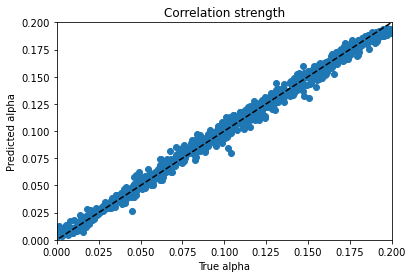

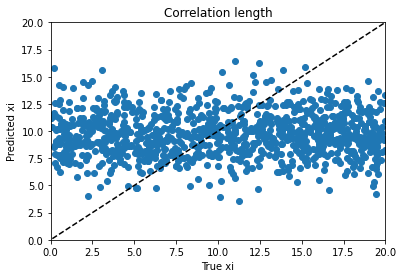

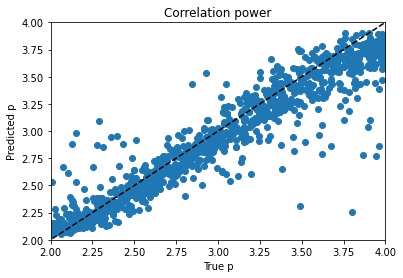

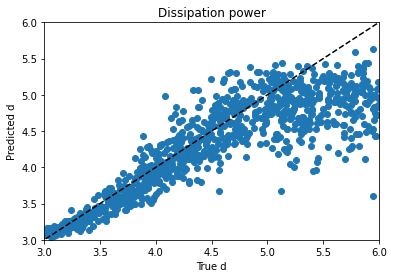

In [ ]:
### COMPLEXCONVNET ###
# check results on TEST set

batch_size = 5

# Get output prediction from neural net
Y_predicted = np.zeros( (len(X_test_norm),4) )
for idx in range(0, len(X_test_std), batch_size):
    inputs = torch.from_numpy(X_test_norm[idx:idx+batch_size]).to(device)
    outputs = complexConvNet(inputs)
    Y_predicted[idx:idx+batch_size,:] = post_process_outputs(outputs).detach().numpy()

show_error(truth=Y_test, predict=Y_predicted)

plt.scatter(Y_test[:,0], Y_predicted[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(Y_test[:,1], Y_predicted[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(Y_test[:,2], Y_predicted[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(Y_test[:,3], Y_predicted[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

(Weighted) alpha Error = 0.0005660860678208905
(Weighted) xi Error = 0.09658789917849926
(Weighted) rho Error = 0.010179854447283664
(Weighted) d Error = 0.022348864749582472
Total error: 0.1296827044431863


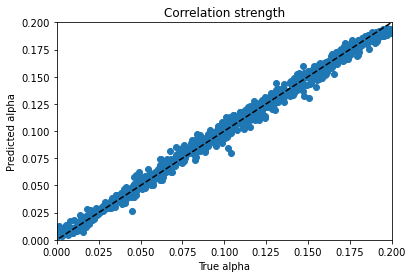

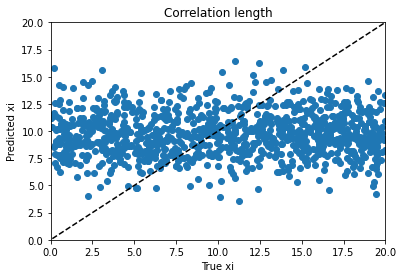

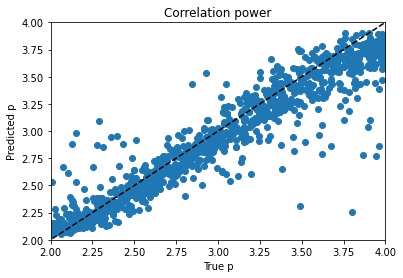

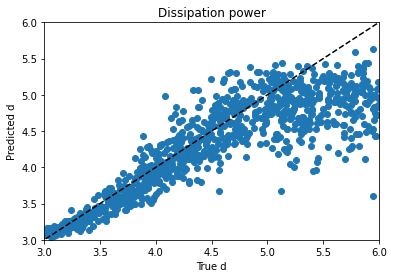

In [ ]:
### COMPLEXCONVNETSAVEDMODEL ###
# check results on TEST set

batch_size = 5

# Get output prediction from neural net
Y_predicted = np.zeros( (len(X_test_norm),4) )
for idx in range(0, len(X_test_std), batch_size):
    inputs = torch.from_numpy(X_test_norm[idx:idx+batch_size]).to(device)
    outputs = complexConvNetSavedModel(inputs)
    Y_predicted[idx:idx+batch_size,:] = post_process_outputs(outputs).detach().numpy()

show_error(truth=Y_test, predict=Y_predicted)

plt.scatter(Y_test[:,0], Y_predicted[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(Y_test[:,1], Y_predicted[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(Y_test[:,2], Y_predicted[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(Y_test[:,3], Y_predicted[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

(Weighted) alpha Error = 0.0005697849871825104
(Weighted) xi Error = 0.07236901521071376
(Weighted) rho Error = 0.007184512861636179
(Weighted) d Error = 0.020562919867734737
Total error: 0.1006862329272672


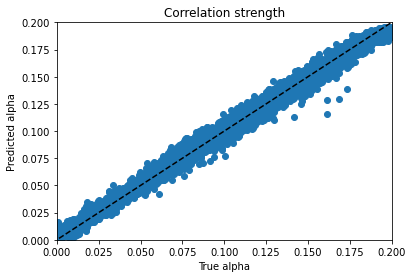

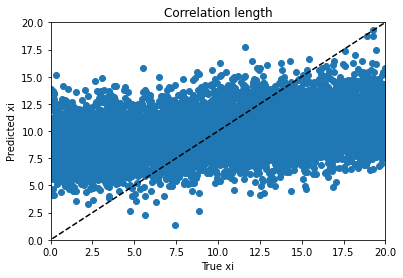

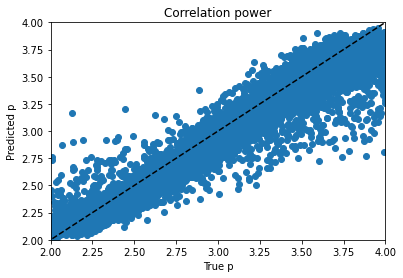

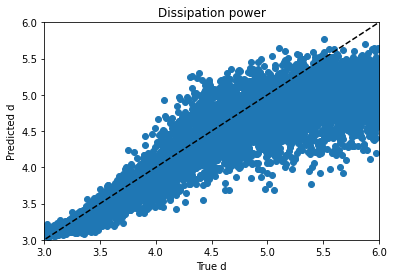

In [ ]:
### COMPLEXCONVNET ###
# check results on TRAIN set

batch_size = 5

# Get output prediction from neural net
Y_predicted = np.zeros( (len(X_train_norm),4) )
for idx in range(0, len(X_train_std), batch_size):
    inputs = torch.from_numpy(X_train_norm[idx:idx+batch_size]).to(device)
    outputs = complexConvNet(inputs)
    Y_predicted[idx:idx+batch_size,:] = post_process_outputs(outputs).detach().numpy()

show_error(truth=Y_train, predict=Y_predicted)

plt.scatter(Y_train[:,0], Y_predicted[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(Y_train[:,1], Y_predicted[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(Y_train[:,2], Y_predicted[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(Y_train[:,3], Y_predicted[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Heatmap of important features in the time domain

It can be helpful to visualize the relative "importance" of each input element by back-propagating gradients of the output. For example, at a given t, we are computing for $\alpha$:

$G_\alpha(t) = \sum_{i} \left| \frac{d \alpha}{d M_i(t)} \right| $

and displaying it in red below as the line indicated with "1".

Does the real part of the data (first half of the x-axis) seem important?

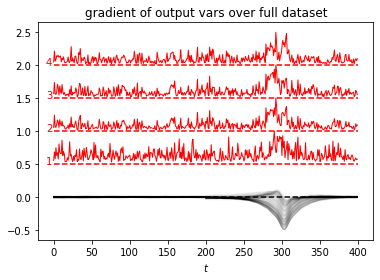

In [ ]:
# heatmap of feature importance in the time domain

plt.plot(M_test[1:300,:].T,color=(0,0,0,.02),linewidth=1);
plt.plot([0,N],[0,0],"--k")

# loop over each output variable
for var_idx in range(4):
    grad_h = np.zeros((np.shape(M_test)[1]))
    s_h = 0.5 + var_idx*0.5;

    # sum over each testing curve, get gradient
    for plot_idx in range(len(M_test)):
        input = torch.from_numpy(M_test[plot_idx])
        input.requires_grad = True
        output = net(input)[var_idx]
        output.backward()
        grad_h = grad_h + abs(input.grad.data.detach().numpy());

    grad_h = 0.5*grad_h/max(grad_h)

    plt.plot(grad_h+s_h,color=(1,0,0),linewidth=1);
    plt.plot([0,N],[s_h,s_h],"--r")
    plt.text(-10,s_h,var_idx+1,color="r")

plt.title("gradient of output vars over full dataset");
plt.xlabel("$t$");

In [ ]:
### LOAD SAVED MODEL ###

# Instantiate model
input_size = X_train_norm.shape[1]
complexConvNetSavedModel = ComplexConvNet(input_dim=input_size)
complexConvNetSavedModel = complexConvNetSavedModel.double().cuda()

# Get path to saved model
model_save_name = 'complexConvNet.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 

# Load model from path saved model
complexConvNetSavedModel.load_state_dict(torch.load(path))
complexConvNetSavedModel.eval()

In [ ]:
### Submission Test Case ###

# M(t) curve for each simulation:
submit_r = np.loadtxt("submit_echos_r.txt", comments="#", delimiter='\t', unpack=False);
submit_i = np.loadtxt("submit_echos_i.txt", comments="#", delimiter='\t', unpack=False);
submit_M = submit_r + 1j*submit_i;
### Partition into Training/Testing with Standardized/Normalized Values ###


### Normalize input ###
# Normalize real component of input data
submit_r_norm, submit_r_min, submit_r_max = norm(submit_r)
# Normalize imaginary component of input data
submit_i_norm, submit_i_min, submit_i_max = norm(submit_i)
# Combine real and imaginary parts of data back together again
submit_M_norm = submit_r_norm + 1j*submit_i_norm


time_keep = range(0,410)
submit_M_norm = submit_M_norm[:, time_keep]
submit_M_norm = np.dstack((np.real(submit_M_norm), np.imag(submit_M_norm)))
submit_M_norm = np.expand_dims(submit_M_norm, axis=2) 


# Batch Size compatible with submission set
submit_batch_size = 5

# Get output prediction from neural net on Submission Dataa
Y_predicted = np.zeros( (len(submit_M_norm),4) )
for idx in range(0, len(submit_M_norm), submit_batch_size):


    inputs = torch.from_numpy(submit_M_norm[idx:idx+submit_batch_size]).to(device)
    
    # Predict call 
    outputs = complexConvNetSavedModel(inputs)

    # Reverse Normalization
    processed = post_process_outputs(outputs).detach().numpy()
    
    # Append outputs
    Y_predicted[idx:idx+submit_batch_size,:] = post_process_outputs(outputs).detach().numpy()

print(Y_predicted.shape)



### CONVERT SUBMISSION DATA TO TEXT FILE ###
with open("./submitted_mat_info.txt", "w") as tfile:
    for row in Y_predicted:
        for col in row:
            tfile.write('{}'.format(col))
            tfile.write('\t')
        tfile.write('\n')

(500, 4)


## Submission format

When we downloaded the data for the model development, we also downloaded 500 spin echos into "submit_echos_r.txt" and "submit_echos_i.txt".
These share the same format as the "echos.txt" used for the model training above.

Use your model to predict the four spin-interaction variables from the 500 echos, and submit your results in a tab delimited .txt file of dimensions 500 x 4 matching the "mat_info.txt" format.

That is, the columns should be:

| $\alpha$ | $\xi$ | $p$ | $d$ |
      
and there should be 500 rows.

Name this file "submitted_mat_info.txt"

The quality of the model will be judged by the minimization of the error function:


$\textrm{Err} = \sum_{v=1}^{4} \sum_{i=i}^{500} \left( \frac{v^i_\textrm{model} - v^i_\textrm{true}}{w(v)} \right)^2 $

where $v^i$ is one of the four spin-interaction variables for echo number $i$, and $w_v$ normalizes the variation in each variable, according to:

$w(\alpha) = 0.2$

$w(\xi) = 20$

$w(p) = 2$

$w(d) = 3.$

Your submission should include your notebook as well as the predicted value file "submitted_mat_info.txt"



## Contributors

- Stephen Carr (Brown Theoretical Physics Center)
- Charles Snider (Brown University)
- J. B. Marston (Brown Theoretical Physics Center)
- V. F. Mitrović (Brown University)
- D. E. Feldman (Brown Theoretical Physics Center)
- C. Ramanathan (Dartmouth College)
